In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation

In [2]:
class AffleckDineMechanism:
    """Simulates the Affleck-Dine mechanism for baryogenesis."""
    
    def __init__(self, m=1.0, lamb=0.1, M=10.0, a=0.1, n=6, H_i=10.0):
        """
        Initialize the Affleck-Dine simulation parameters.
        
        Parameters:
        -----------
        m : float
            Mass parameter for the scalar field
        lamb : float
            Self-coupling parameter
        M : float
            Scale parameter in denominator of quartic term
        a : float
            Coefficient of CP-violating term
        n : int
            Power in the CP-violating term (typically 4 or 6)
        H_i : float
            Initial Hubble parameter
        """
        self.m = m
        self.lamb = lamb
        self.M = M
        self.a = complex(0, a)  # Make 'a' imaginary for explicit CP violation
        self.n = n
        self.H_i = H_i
    
    def hubble_parameter(self, t):
        """
        Calculate the Hubble parameter at time t.
        
        Assuming matter domination: H(t) = 2/(3t)
        """
        # Prevent division by zero at t=0
        t_safe = max(t, 1e-10)
        return self.H_i / (1 + t/t_safe)
    
    def potential_derivative(self, phi):
        """
        Calculate the derivative of the potential with respect to phi*.
        
        Parameters:
        -----------
        phi : complex
            The complex scalar field
        
        Returns:
        --------
        dV_dphi_star : complex
            The derivative of the potential
        """
        # m^2 |phi|^2 term
        term1 = self.m**2 * phi
        
        # lambda |phi|^4/M^2 term
        term2 = 2 * self.lamb * (abs(phi)**2) * phi / self.M**2
        
        # (a m phi^n + h.c.) term - only derivative of the h.c. part contributes
        # The hermitian conjugate term is (a m phi^n)* = a* m phi*^n
        # Derivative w.r.t. phi* is n * a* m * (phi*)^(n-1)
        term3 = self.n * np.conjugate(self.a) * self.m * np.conjugate(phi)**(self.n-1)
        
        return term1 + term2 + term3
    
    def field_equations(self, t, y):
        """
        The system of differential equations for the scalar field.
        
        Parameters:
        -----------
        t : float
            Time
        y : array
            [Re(phi), Im(phi), Re(phi_dot), Im(phi_dot)]
        
        Returns:
        --------
        dydt : array
            Derivatives of the state variables
        """
        # Extract state variables
        phi_real, phi_imag, phi_dot_real, phi_dot_imag = y
        phi = complex(phi_real, phi_imag)
        phi_dot = complex(phi_dot_real, phi_dot_imag)
        
        # Calculate Hubble parameter
        H = self.hubble_parameter(t)
        
        # Calculate potential derivative
        dV_dphi_star = self.potential_derivative(phi)
        
        # Equation of motion: phi_ddot + 3H*phi_dot + dV/dphi* = 0
        phi_ddot = -3 * H * phi_dot - dV_dphi_star
        
        # Convert complex numbers back to real and imaginary parts
        phi_ddot_real = phi_ddot.real
        phi_ddot_imag = phi_ddot.imag
        
        return [phi_dot_real, phi_dot_imag, phi_ddot_real, phi_ddot_imag]
    
    def calculate_baryon_asymmetry(self, phi, phi_dot):
        """
        Calculate the baryon asymmetry.
        
        Parameters:
        -----------
        phi : complex
            Scalar field
        phi_dot : complex
            Time derivative of scalar field
        
        Returns:
        --------
        n_B : float
            Baryon asymmetry (proportional to Im(phi phi_dot*))
        """
        return np.imag(phi * np.conjugate(phi_dot))
    
    def solve(self, t_span, initial_conditions, t_eval=None):
        """
        Solve the field equations over the given time span.
        
        Parameters:
        -----------
        t_span : tuple
            (t_start, t_end) time span for integration
        initial_conditions : array
            [Re(phi_0), Im(phi_0), Re(phi_dot_0), Im(phi_dot_0)]
        t_eval : array or None
            Specific times to evaluate solution at
        
        Returns:
        --------
        solution : OdeSolution
            Solution from the ODE solver
        """
        return solve_ivp(
            self.field_equations, 
            t_span, 
            initial_conditions, 
            method='RK45', 
            t_eval=t_eval
        )
    
    def plot_results(self, sol):
        """
        Plot the evolution of the field and baryon asymmetry.
        
        Parameters:
        -----------
        sol : OdeSolution
            Solution from the ODE solver
        """
        # Extract solution
        t = sol.t
        phi_real = sol.y[0]
        phi_imag = sol.y[1]
        phi_dot_real = sol.y[2]
        phi_dot_imag = sol.y[3]
        
        # Calculate derived quantities
        phi = phi_real + 1j * phi_imag
        phi_dot = phi_dot_real + 1j * phi_dot_imag
        
        phi_mag = np.abs(phi)
        phi_arg = np.angle(phi)
        n_B = self.calculate_baryon_asymmetry(phi, phi_dot)
        
        # Create figure with 3 subplots
        fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
        
        # Plot field magnitude
        axs[0].plot(t, phi_mag)
        axs[0].set_ylabel(r'$|\phi|$')
        axs[0].set_title('Affleck-Dine Scalar Field Evolution')
        axs[0].grid(True)
        
        # Plot field phase
        axs[1].plot(t, phi_arg)
        axs[1].set_ylabel(r'$\arg(\phi)$')
        axs[1].grid(True)
        
        # Plot baryon asymmetry
        axs[2].plot(t, n_B)
        axs[2].set_ylabel(r'$n_B \propto \mathrm{Im}(\phi\dot{\phi}^*)$')
        axs[2].set_xlabel('Time')
        axs[2].grid(True)
        
        plt.tight_layout()
        return fig
    
    def plot_field_trajectory(self, sol):
        """
        Plot the trajectory of the field in the complex plane.
        
        Parameters:
        -----------
        sol : OdeSolution
            Solution from the ODE solver
        """
        # Extract solution
        phi_real = sol.y[0]
        phi_imag = sol.y[1]
        
        # Create figure
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # Plot trajectory
        ax.plot(phi_real, phi_imag)
        ax.scatter(phi_real[0], phi_imag[0], color='green', s=100, label='Start')
        ax.scatter(phi_real[-1], phi_imag[-1], color='red', s=100, label='End')
        
        # Add arrows to show direction
        n_arrows = 10
        indices = np.linspace(0, len(phi_real)-1, n_arrows, dtype=int)
        for i in indices[:-1]:
            ax.annotate('', 
                        xy=(phi_real[i+1], phi_imag[i+1]), 
                        xytext=(phi_real[i], phi_imag[i]),
                        arrowprops=dict(arrowstyle='->', lw=1.5, color='blue'))
        
        # Set labels and title
        ax.set_xlabel(r'Re($\phi$)')
        ax.set_ylabel(r'Im($\phi$)')
        ax.set_title('Scalar Field Trajectory in Complex Plane')
        ax.grid(True)
        ax.axis('equal')
        ax.legend()
        
        return fig

def run_affleck_dine_simulation():
    """Run a demonstration of the Affleck-Dine mechanism."""
    
    # Initialize model with appropriate parameters
    # The CP-violating phase is introduced through an imaginary 'a' parameter
    ad = AffleckDineMechanism(
        m=1.0,        # Mass parameter
        lamb=0.1,      # Self-coupling
        M=10.0,        # Scale in denominator
        a=0.1,         # CP-violating parameter (will be made imaginary)
        n=6,           # Power in CP-violating term
        H_i=5.0        # Initial Hubble parameter
    )
    
    # Time span for integration
    t_span = (0, 20)
    
    # Initial conditions: [Re(phi_0), Im(phi_0), Re(phi_dot_0), Im(phi_dot_0)]
    # Choose initial conditions with large field value and small time derivative
    initial_conditions = [5.0, 2.0, 0.0, 0.0]
    
    # Specific times to evaluate solution
    t_eval = np.linspace(t_span[0], t_span[1], 500)
    
    # Solve the differential equations
    print("Solving Affleck-Dine scalar field equations...")
    sol = ad.solve(t_span, initial_conditions, t_eval)
    
    # Plot results
    print("Plotting results...")
    fig1 = ad.plot_results(sol)
    fig1.savefig('affleck_dine_evolution.png')
    
    fig2 = ad.plot_field_trajectory(sol)
    fig2.savefig('affleck_dine_trajectory.png')
    
    # Create an animation of the field evolution
    print("Creating animation...")
    
    # Extract solution
    t = sol.t
    phi_real = sol.y[0]
    phi_imag = sol.y[1]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    line, = ax.plot([], [])
    point, = ax.plot([], [], 'ro', markersize=8)
    
    ax.set_xlabel(r'Re($\phi$)')
    ax.set_ylabel(r'Im($\phi$)')
    ax.set_title('Scalar Field Evolution in Complex Plane')
    
    # Set axis limits with some padding
    max_real = max(abs(phi_real)) * 1.1
    max_imag = max(abs(phi_imag)) * 1.1
    ax.set_xlim(-max_real, max_real)
    ax.set_ylim(-max_imag, max_imag)
    ax.grid(True)
    
    def init():
        line.set_data([], [])
        point.set_data([], [])
        return line, point
    
    def animate(i):
        line.set_data(phi_real[:i+1], phi_imag[:i+1])
        point.set_data(phi_real[i], phi_imag[i])
        return line, point
    
    ani = FuncAnimation(fig, animate, frames=len(t), init_func=init, 
                        interval=50, blit=True)
    
    # Save animation (optional)
    # ani.save('affleck_dine_animation.gif', writer='pillow', fps=30)
    
    # Show all plots
    plt.show()
    
    # Print summary of results
    phi_final = complex(phi_real[-1], phi_imag[-1])
    phi_dot_final = complex(sol.y[2][-1], sol.y[3][-1])
    n_B_final = ad.calculate_baryon_asymmetry(phi_final, phi_dot_final)
    
    print("\nSimulation Results:")
    print(f"Final field magnitude: |φ| = {abs(phi_final):.4f}")
    print(f"Final field phase: arg(φ) = {np.angle(phi_final):.4f} radians")
    print(f"Final baryon asymmetry: n_B ∝ {n_B_final:.4e}")
    
    return ad, sol

def study_parameter_dependence():
    """Study how the baryon asymmetry depends on model parameters."""
    # Base parameters
    m = 1.0
    lamb = 0.1
    M = 10.0
    a_base = 0.1
    n = 6
    H_i = 5.0
    
    # Vary the CP-violating parameter
    a_values = np.linspace(0.01, 0.2, 10)
    
    # Time span and initial conditions
    t_span = (0, 20)
    initial_conditions = [5.0, 2.0, 0.0, 0.0]
    
    # Store final baryon asymmetries
    n_B_finals = []
    
    print("Studying parameter dependence...")
    for a in a_values:
        # Create model with this a value
        ad = AffleckDineMechanism(m=m, lamb=lamb, M=M, a=a, n=n, H_i=H_i)
        
        # Solve
        sol = ad.solve(t_span, initial_conditions)
        
        # Extract final state
        phi_final = complex(sol.y[0][-1], sol.y[1][-1])
        phi_dot_final = complex(sol.y[2][-1], sol.y[3][-1])
        
        # Calculate final baryon asymmetry
        n_B_final = ad.calculate_baryon_asymmetry(phi_final, phi_dot_final)
        n_B_finals.append(n_B_final)
    
    # Plot the dependence
    plt.figure(figsize=(10, 6))
    plt.plot(a_values, n_B_finals, 'o-')
    plt.xlabel('CP-violating parameter (a)')
    plt.ylabel('Final baryon asymmetry')
    plt.title('Dependence of Baryon Asymmetry on CP Violation')
    plt.grid(True)
    plt.savefig('parameter_dependence.png')
    plt.show()

Solving Affleck-Dine scalar field equations...
Plotting results...
Creating animation...


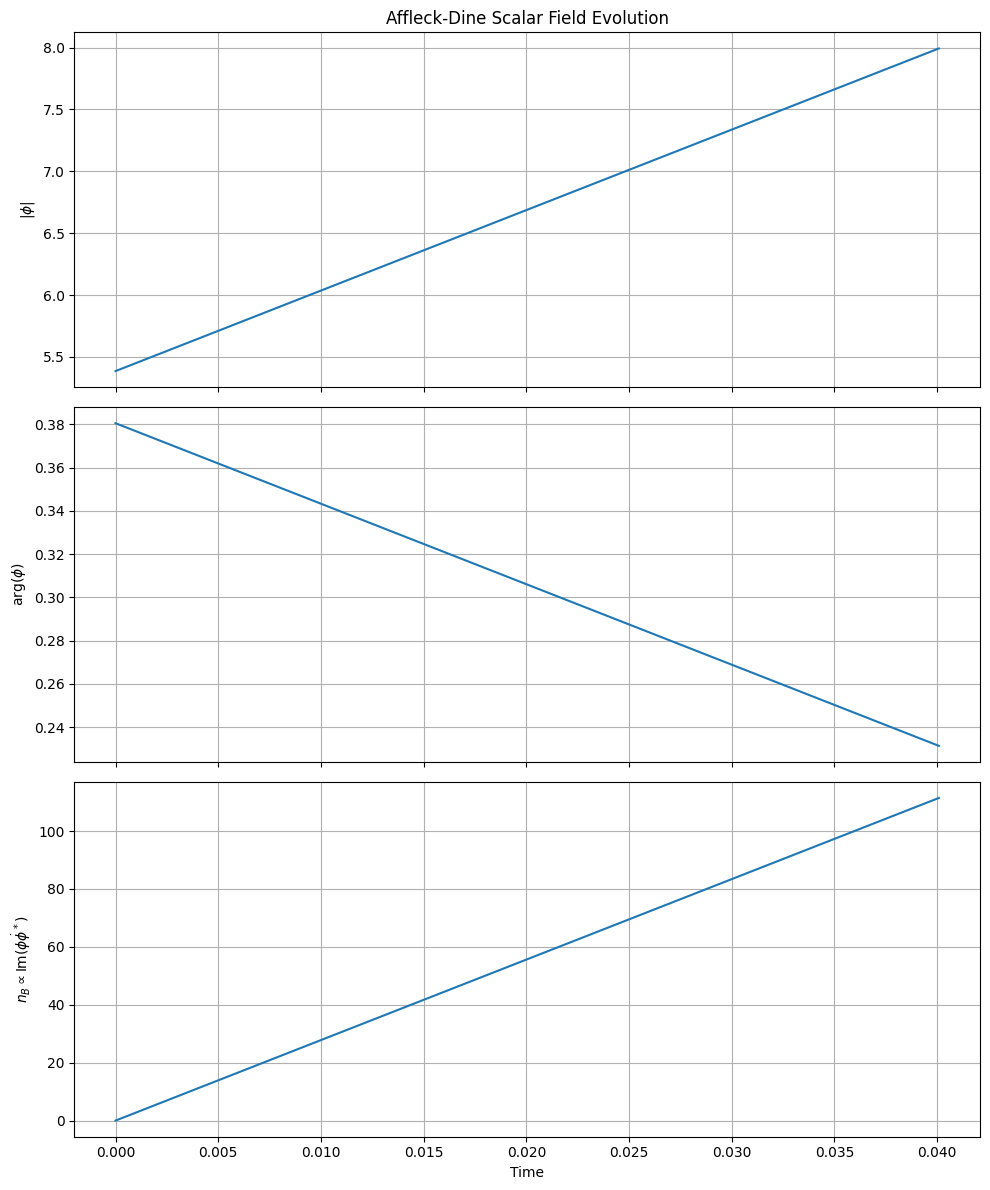

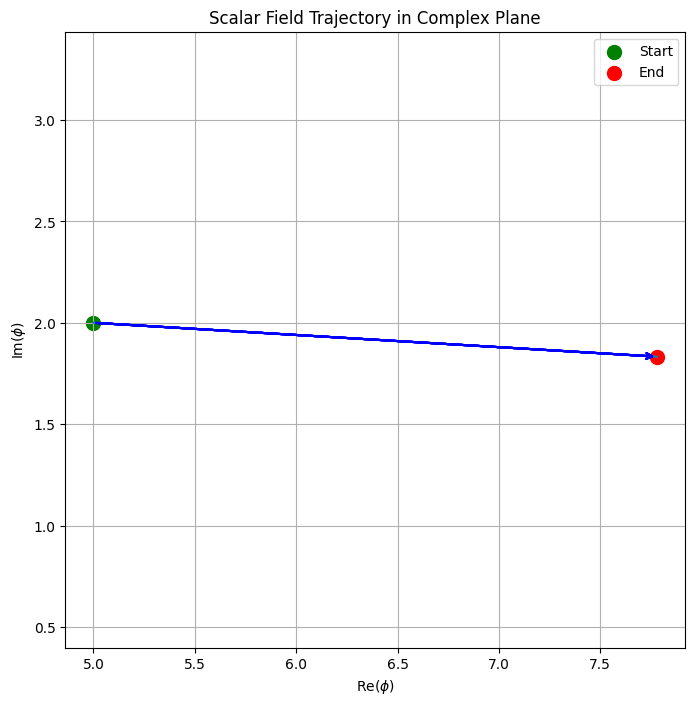

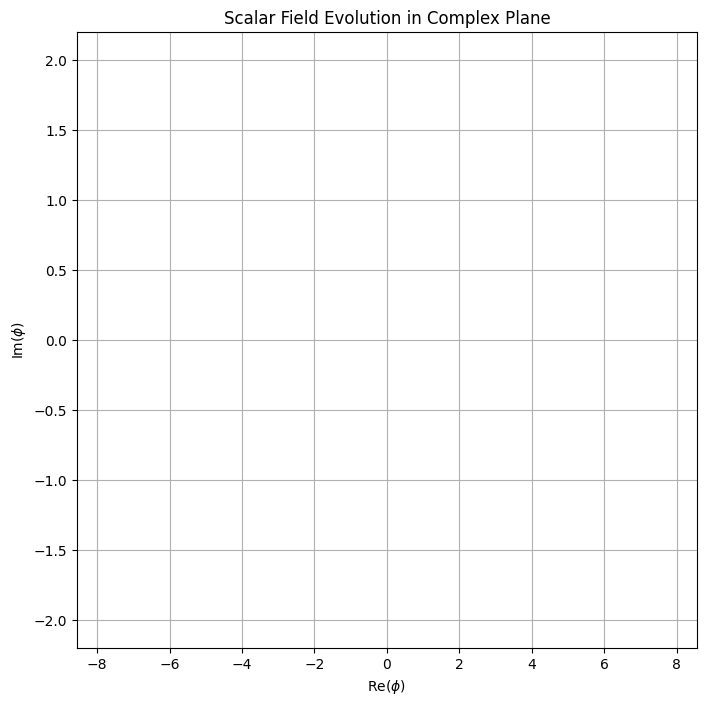


Simulation Results:
Final field magnitude: |φ| = 7.9931
Final field phase: arg(φ) = 0.2314 radians
Final baryon asymmetry: n_B ∝ 1.1144e+02
Studying parameter dependence...


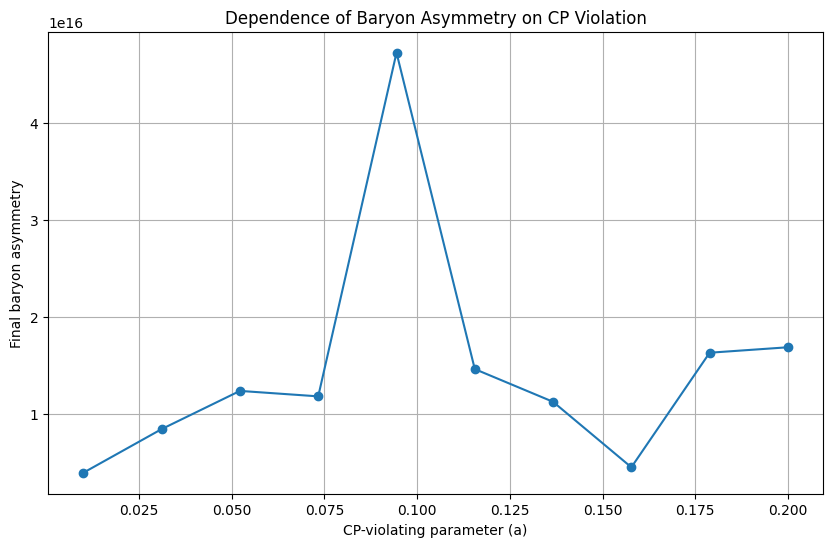

In [3]:
if __name__ == "__main__":
    # Run the main simulation
    ad, sol = run_affleck_dine_simulation()
    
    # Study parameter dependence
    study_parameter_dependence()